In [18]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

from dataloader import *

sns.set(style='ticks', context='talk')
plt.style.use("paper.mplstyle")

## Data

### Campbell HR and Local Age

Missing from R19 Table 1 of SNID: {15459}
Missing from Campbell MCMC chains of SNID: {3256}
Resulting data will be an inner join of the two remove all SNID mentioned above


,hr,hr_err,age_list,age_len,age_mean,age_std
snid,,,,,,
762,0.15,0.08,"[2.021842443059973, 2.8339090563462914, 2.5803...",10000.0,5.104795,2.393743
1032,-0.15,0.12,"[8.566398687694987, 6.174779460678963, 6.30802...",10000.0,5.599738,2.347868
1371,-0.14,0.06,"[10.286073950592902, 10.295291923872872, 9.059...",10000.0,7.137418,3.674216
1794,0.27,0.08,"[6.0175019232928975, 4.3212545611169455, 4.644...",10000.0,3.928420,1.359435
2372,-0.12,0.07,"[5.547124358695184, 8.033530211971897, 4.95413...",10000.0,5.909050,1.673404
...,...,...,...,...,...,...
20764,-0.18,0.09,"[8.177679869720638, 7.591316094433424, 10.4262...",10000.0,8.752378,2.449585
21034,0.08,0.06,"[4.993231855757519, 1.8572530306651427, 2.5932...",10000.0,3.366768,1.087121
21487,-0.30,0.08,"[5.099835229010738, 6.674473691261, 3.36676690...",10000.0,5.178159,0.997140


/home/keto/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


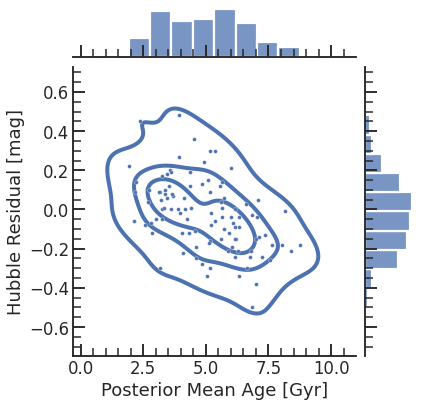

In [2]:
age_df = load_age_sample_from_mcmc_chains('campbell', mode="read")
hr_df = load_hr("campbell")
age_df, hr_df = clean_data(age_df, hr_df)
snids = age_df.index.unique().tolist()

display(hr_df.join(age_df["age"].groupby('snid').agg([list, len, np.mean, np.std]).add_prefix("age_")))

# Joint plot of Age and HR row means
sns.jointplot(age_df.groupby('snid').mean()['age'], hr_df['hr'], s=15).plot_joint(sns.kdeplot, zorder=0, n_levels=4)
plt.xlabel("Posterior Mean Age [Gyr]")
plt.ylabel("Hubble Residual [mag]")
plt.show()

In [33]:
from tqdm  import trange

results = {}
for i in trange(len(snids)):
    snid = snids[i]
    x = age_df.loc[snid, :].to_numpy()
    gmm = GaussianMixture(n_components=2, covariance_type='spherical').fit(x)
    results[snid] = gmm
    

100%|██████████| 102/102 [00:37<00:00,  2.73it/s]


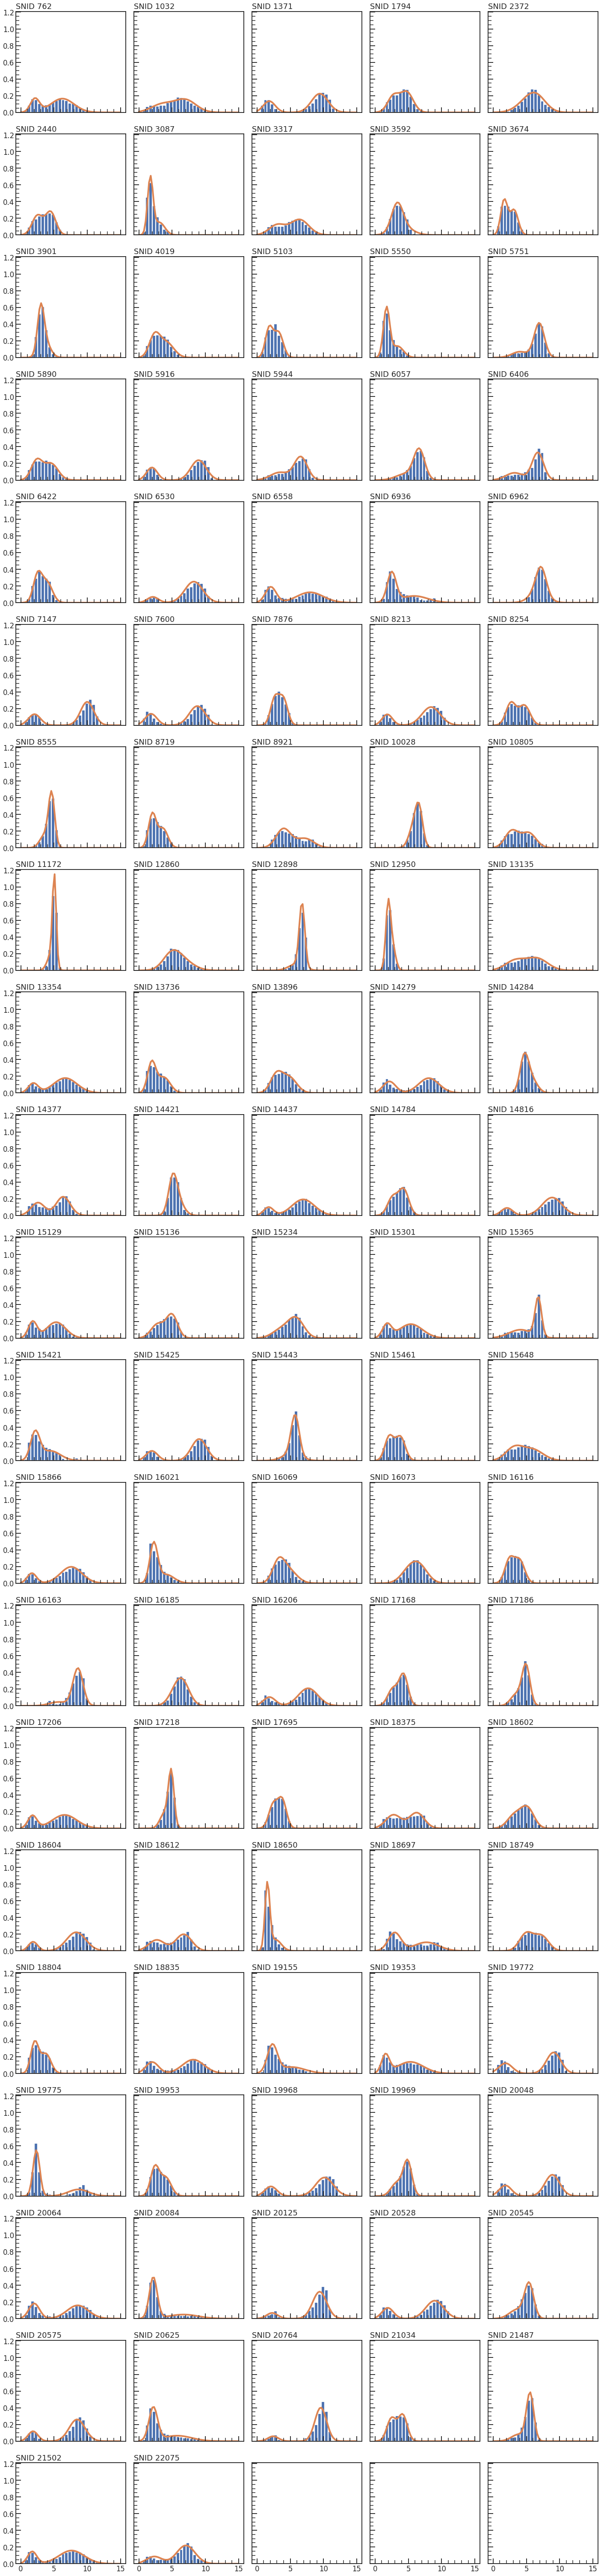

In [45]:
nrows, ncols = 21, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4), sharex=True, sharey=True)

xrange = np.linspace(0, 15, 60)
bins = xrange[::2]
random_snids = snids
for i in range(nrows*ncols):
    if i >= len(random_snids):
        break
    else:    
        snid = random_snids[i]
    
    ax = axs[i//ncols, i%ncols]
    ax.set_title(f"SNID {snid}", loc="left")
    
    ax.hist(age_df.loc[snid, :], bins, density=True)
    
    gmm = results[snid]
    probs = np.exp(gmm.score_samples(xrange.reshape(-1, 1)))
    ax.plot(xrange, probs)

plt.tight_layout()

## Correlation Analysis

* The biggest argument between Rose19 (or Rose20) and Lee20 is whether there is a correlation between HR and Age.
* Possible conclusions are:

    1. not enough data points
    2. there is no correlation
    3. there is a significant correlation, but it is not strong enough to deny dark energy
    4. there is a significant correlation, but slope is not large enough to deny dark energy
    5. there is a significant correlation, and slope is large enough to deny dark energy


notes:
* Lee20 claims number of samples causes 'dilution problem': how can we say this claim is not on point?
* Lee20 claims 'proper method' yields a large slope. If there are correlations, what is the slope?

### Statistical Simulation - Sampling Age and Hubble Residual
To determine correlation, statistical simulation by sampling the age and HR simulation joint distribution provides a estimate of the true correlation without the need for model-fitting. For each SNe, the variablility of age and HR is accounted for with large enough samples of each distribution.

For each of the $N_\text{snid}$ SNe,

* 10000 samples without replacement of HR assuming Gaussian distribution given it respective parameters.
* 10000 samples without replacement of Age given the MCMC-derived posterior sample with no fitting of its distribution.

The total sample size is $N_\text{snid} \times 10000$

In [3]:
def simulate(age_df, hr_df, reps=1000):
    assert len(age_df.index.unique()) == len(hr_df)
    sample_size = len(hr_df)
    
    corrs = []
    rcorrs = []
    slopes = []
    intercepts = []
    for i in range(reps):
        xsample = age_df.groupby('snid').sample(1)['age']
        
        ydist = stats.norm(loc=hr_df['hr'], scale=hr_df['hr_err'])
        ysample = ydist.rvs(sample_size)
        
        corr = stats.pearsonr(xsample, ysample)[0]
        corrs.append(corr)
        
        rcorr = stats.spearmanr(xsample, ysample)[0]
        rcorrs.append(rcorr)

        slope = corr * (np.std(ysample) / np.std(xsample))
        slopes.append(slope)
        
        intercept = np.mean(ysample) - slope*np.mean(xsample)
        intercepts.append(intercept)
        
        if (i+1) % 100 == 0: 
            print(f"{i+1}/{reps}", end="\r")
    
    
    result_df = pd.DataFrame({"corr": corrs, "rcorr": rcorrs, "slope": slopes, "intercept": intercept})
    result_df.to_csv(RESULTSPATH/"campbell_hr_age_simulation.csv", index=False)

def get_simulation():
    return pd.read_csv(RESULTSPATH/"campbell_hr_age_simulation.csv")

# simulate(age_df, hr_df)
result_df = get_simulation()

### Simulation Results

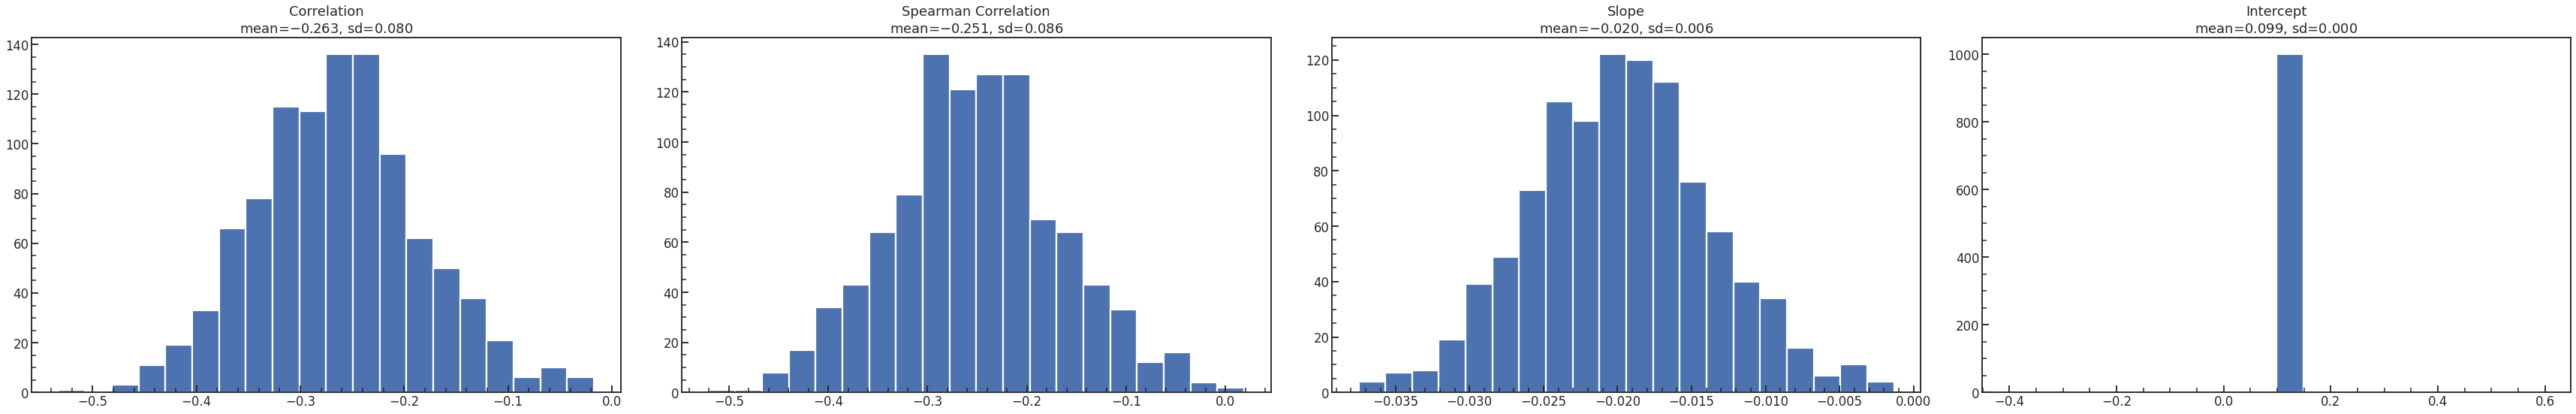

In [4]:
ncols = len(result_df.columns)
fig, axes = plt.subplots(ncols=ncols, figsize=(12*ncols, 8))
titles = {
    "corr": "Correlation",
    "rcorr": "Spearman Correlation",
    "slope": "Slope",
    "intercept": "Intercept"
}

for i, col in enumerate(result_df.columns):
    ax = axes[i]
    ax.hist(result_df[col], bins=20)
    ax.set_title(f"{titles[col]}\nmean=${result_df[col].mean():.3f}$, sd=${result_df[col].std():.3f}$")
    
plt.tight_layout()

In [5]:
# def get_slope_parameter(x, y):
#     """Return the mean and variance of the OLS slope parameter"""
#     corr = stats.pearsonr(x, y)[0]
#     slope = corr * (np.std(y) / np.std(x))
    
#     sigma2 = (np.var(y)**2 + np.var(x)**2)
#     slope_var = sigma2 / np.sum((x-np.mean(x))**2)
    
#     return slope, slope_var

# x, y = result_df['age'], result_df['hr']
# corr, pvalue_corr = stats.pearsonr(x, y)
# rcorr, pvalue_rcorr = stats.spearmanr(x, y)
# slope, slope_var = get_slope_parameter(x, y)
# intercept = np.mean(y) - slope*np.mean(x)

# plt.figure(figsize=(8,8))
# plt.hist2d(x, y, bins=100, cmap='gray_r')

# xrange = np.linspace(0, 12, 100)
# plt.plot(xrange, slope*xrange + intercept, lw=3)

# plt.annotate(f"Pearson Correlation: {corr:.3f}, p={pvalue_corr:.3f}\nSpearman Correlation: {rcorr:.3f}, p={pvalue_rcorr:.3f}", xy=(0.05, 0.90), xycoords='axes fraction')
# plt.xlabel("Local age [Gyr]")
# plt.ylabel("Hubble residual [mag]")
# plt.xticks(np.arange(0, 14, 2))
# plt.yticks(np.arange(-1, 1.5, 0.5));

### Correlation Analysis with All Gaussian Errors

Attempting to incorrectly do correlation analysis that L20 did which changes the previous correlation analysis by the assumption of the Age distribution:

* 10000 samples without replacement of Age assumed to be <span style="color: red">Gaussian parameters from the MCMC-derived posterior mean and SD</span>.

In [6]:
def simulate_with_gaussian(age_df, hr_df, reps=1000):
    assert len(age_df.index.unique()) == len(hr_df)
    sample_size = len(hr_df)
    
    corrs = []
    rcorrs = []
    slopes = []
    intercepts = []
    for i in range(reps):
        xdist = stats.norm(loc=age_df['age'].groupby('snid').mean(), scale=age_df['age'].groupby('snid').std())
        xsample = xdist.rvs(sample_size)
        
        ydist = stats.norm(loc=hr_df['hr'], scale=hr_df['hr_err'])
        ysample = ydist.rvs(sample_size)
        
        corr = stats.pearsonr(xsample, ysample)[0]
        corrs.append(corr)
        
        rcorr = stats.spearmanr(xsample, ysample)[0]
        rcorrs.append(rcorr)

        slope = corr * (np.std(ysample) / np.std(xsample))
        slopes.append(slope)
        
        intercept = np.mean(ysample) - slope*np.mean(xsample)
        intercepts.append(intercept)
        
        if (i+1) % 100 == 0: 
            print(f"{i+1}/{reps}", end="\r")
            
    result_df = pd.DataFrame({"corr": corrs, "rcorr": rcorrs, "slope": slopes, "intercept": intercept})
    result_df.to_csv(RESULTSPATH/"campbell_hr_age_gaussian_simulation.csv", index=False)

def get_simulation_with_gaussian():
    return pd.read_csv(RESULTSPATH/"campbell_hr_age_gaussian_simulation.csv")

# simulate_with_gaussian(age_df, hr_df)
result_gaussian_df = get_simulation_with_gaussian()

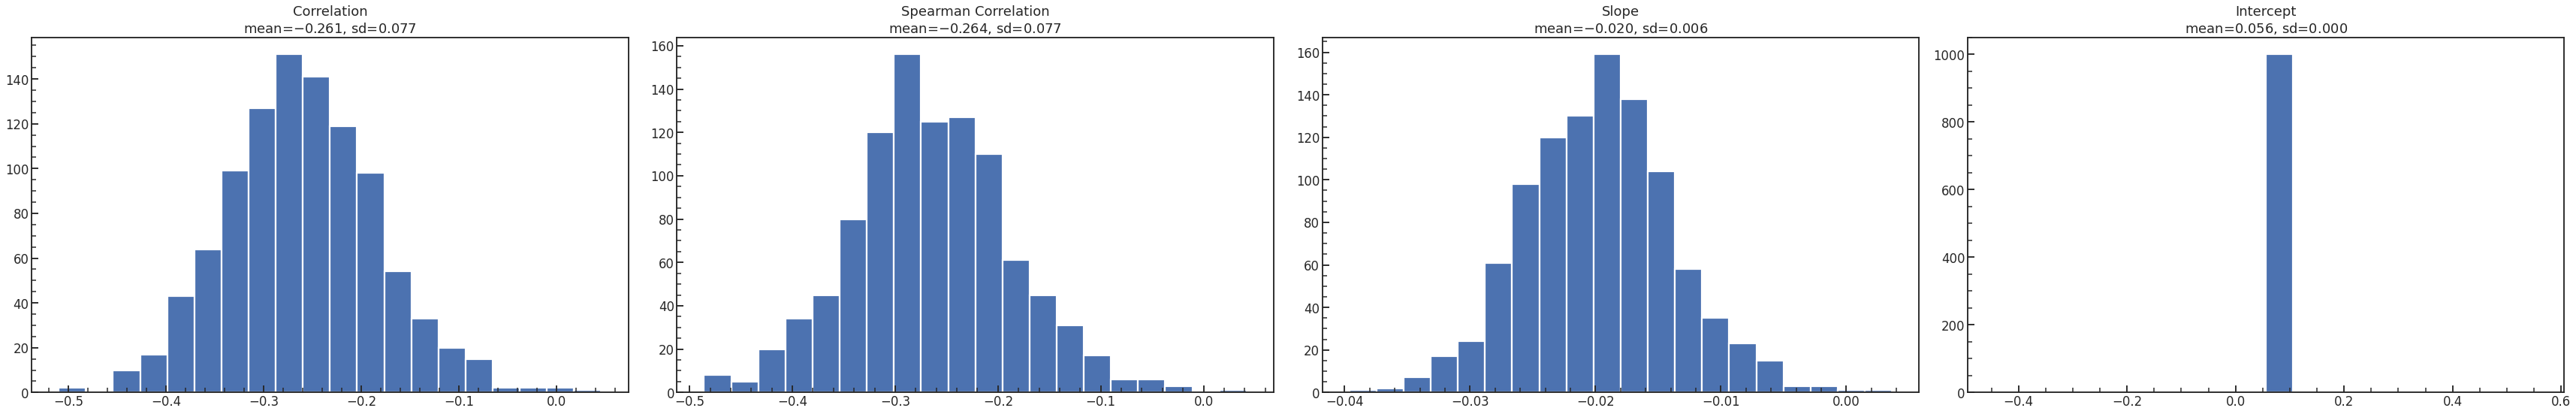

In [7]:
ncols = len(result_gaussian_df.columns)
fig, axes = plt.subplots(ncols=ncols, figsize=(12*ncols, 8))
titles = {
    "corr": "Correlation",
    "rcorr": "Spearman Correlation",
    "slope": "Slope",
    "intercept": "Intercept"
}

for i, col in enumerate(result_gaussian_df.columns):
    ax = axes[i]
    ax.hist(result_gaussian_df[col], bins=20)
    ax.set_title(f"{titles[col]}\nmean=${result_gaussian_df[col].mean():.3f}$, sd=${result_gaussian_df[col].std():.3f}$")
    
plt.tight_layout()

In [8]:
# x, y = result_gaussian_df['age'], result_gaussian_df['hr']
# corr, pvalue_corr = stats.pearsonr(x, y)
# rcorr, pvalue_rcorr = stats.spearmanr(x, y)
# slope = corr * (np.std(y) / np.std(x))
# intercept = np.mean(y) - slope*np.mean(x)

# plt.figure(figsize=(8,8))
# cut = (x > 0) & (x < 12)
# plt.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')

# xrange = np.linspace(0, 12, 100)
# plt.plot(xrange, slope*xrange + intercept, lw=3)

# plt.annotate(f"Pearson Correlation: {corr:.3f}, p={pvalue_corr:.3f}\nSpearman Correlation: {rcorr:.3f}, p={pvalue_rcorr:.3f}", xy=(0.05, 0.90), xycoords='axes fraction')
# plt.xlabel("Local age [Gyr]")
# plt.ylabel("Hubble residual [mag]")
# plt.xticks(np.arange(0, 14, 2))
# plt.yticks(np.arange(-1, 1.5, 0.5))

In [9]:
# plt.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')
# plt.errorbar(
#     age_df.groupby('snid').mean()["age"], 
#     hr_df.groupby('snid').mean()["hr"], 
#     xerr=age_df.groupby('snid').std()["age"], 
#     yerr=hr_df["hr"].groupby('snid').apply(lambda s: np.sqrt(np.sum(s**2))), 
#     fmt='.', lw=1)

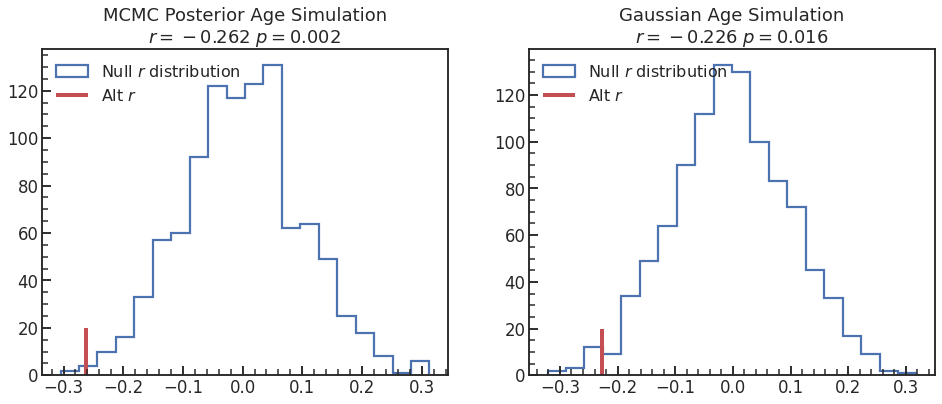

In [9]:
def correlation_test(x, y, corr_func=stats.pearsonr, sample_size=100, repetition=1000):
    """Test the significance of the correlation with null hypothesis of zero correlation"""
    corr = corr_func(x, y)[0] # We will ignore 2nd arg which is the p-value
    
    corr_samples = []
    for i in range(repetition):
        x_sample = np.random.choice(x, size=sample_size)
        y_sample = np.random.choice(y, size=sample_size)
        corr_sample = corr_func(x_sample, y_sample)[0]
        corr_samples.append(corr_sample)
    
    pvalue = np.mean(corr_samples <= corr)
    return corr, pvalue, corr_samples

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax = axes[0]
_corr, _pvalue, _corr_samples = correlation_test(result_df['age'], result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ distribution")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"MCMC Posterior Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.legend(loc='upper left')

ax = axes[1]
_corr, _pvalue, _corr_samples = correlation_test(result_gaussian_df['age'], result_gaussian_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ distribution")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"Gaussian Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.legend(loc='upper left')


## Summary

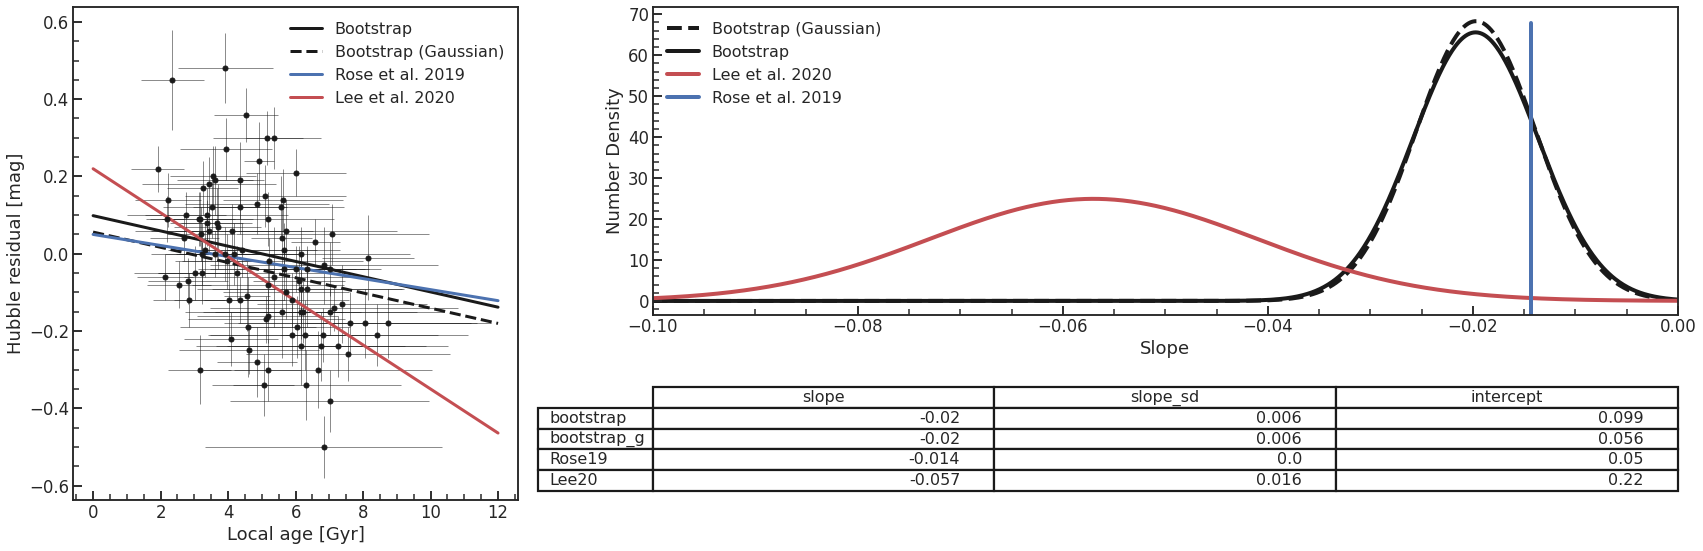

In [244]:
summary_df = pd.DataFrame({
                            "bootstrap":  {
                                "slope": result_df["slope"].mean(),
                                "slope_sd": result_df["slope"].std(),
                                "intercept": result_df["intercept"].mean(),
                            },
                            "bootstrap_g": {
                                "slope": result_gaussian_df["slope"].mean(),
                                "slope_sd": result_gaussian_df["slope"].std(),
                                "intercept": result_gaussian_df["intercept"].mean(),
                            },
                            "Rose19": {
                                "slope": -0.1/7,
                                "slope_sd": 0,
                                "intercept": 0.05
                            },
                            "Lee20": {
                                "slope": -0.057,
                                "slope_sd": 0.016,
                                "intercept": 0.22
                            },
                         })

fig = plt.figure(figsize=(24, 8))
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((3, 3), (2, 1), colspan=2)

ax1.errorbar(age_df["age"].groupby('snid').mean(), hr_df["hr"], xerr=age_df["age"].groupby('snid').std(), yerr=hr_df['hr_err'], fmt='ko', lw=0.5, ms=5)
xrange = np.linspace(0, 12, 100)

slope, intercept = summary_df.loc[["slope", "intercept"], "bootstrap"]
ax1.plot(xrange, slope*xrange + intercept, 'k', lw=3, label=f"Bootstrap")

slope, intercept = summary_df.loc[["slope", "intercept"], "bootstrap_g"]
ax1.plot(xrange, slope*xrange + intercept, 'k--', lw=3, label=f"Bootstrap (Gaussian)")

slope, intercept = summary_df.loc[["slope", "intercept"], "Rose19"]
ax1.plot(xrange, slope*xrange + intercept, lw=3, label=f"Rose et al. 2019")

slope, intercept = summary_df.loc[["slope", "intercept"], "Lee20"]
ax1.plot(xrange, slope*xrange + intercept, 'r', lw=3, label=f"Lee et al. 2020")

ax1.legend()
ax1.set_xlabel("Local age [Gyr]")
ax1.set_ylabel("Hubble residual [mag]")

xrange = np.linspace(-0.1, 0, 1000)
# ax2.hist([result_df['slope'], result_gaussian_df['slope']], density=True, bins=15, color=["k", "gray"], label=["Bootstrap", "Bootstrap (Gaussian)"])
ax2.plot(xrange, stats.norm(loc=summary_df.loc["slope", "bootstrap_g"], scale=summary_df.loc["slope_sd", "bootstrap_g"]).pdf(xrange), "k--", label="Bootstrap (Gaussian)")
ax2.plot(xrange, stats.norm(loc=summary_df.loc["slope", "bootstrap"], scale=summary_df.loc["slope_sd", "bootstrap"]).pdf(xrange), "k", label="Bootstrap")
ax2.plot(xrange, stats.norm(loc=summary_df.loc["slope", "Lee20"], scale=summary_df.loc["slope_sd", "Lee20"]).pdf(xrange), c="r", label="Lee et al. 2020")
ax2.axvline(summary_df.loc["slope", "Rose19"], ymax=0.95, label="Rose et al. 2019")

ax2.legend()
ax2.set_xlabel("Slope")
ax2.set_ylabel("Number Density")
ax2.set_xlim(-0.1, 0)

plt_table= pd.plotting.table(ax3, summary_df.T.round(3), loc='center')
plt_table.auto_set_font_size(False)
plt_table.set_fontsize(16)
plt_table.scale(1., 1.8)

ax3.axis("off")
plt.tight_layout()

In [191]:
(result_df['slope'].mean() - summary_df.loc['slope', 'Lee20']) / np.sqrt(result_df['slope'].std()**2 + summary_df.loc['slope_sd', 'Lee20']**2)

2.176918810061037

In [192]:
from itertools import combinations

def get_discrepancy(x, y, xerr, yerr):
    return (x - y) / np.sqrt(xerr**2 + yerr**2)


for cols in list(combinations(summary_df.columns, 2)):
    _df = summary_df.loc[["slope", "slope_sd"], list(cols)].T
    display(_df)
    print(get_discrepancy(_df.iloc[0, 0], _df.iloc[1, 0], _df.iloc[0, 1], _df.iloc[1, 1]))

,slope,slope_sd
bootstrap,-0.019737,0.006083
bootstrap_g,-0.019699,0.005840


-0.0045328098921561056


,slope,slope_sd
bootstrap,-0.019737,0.006083
Rose19,-0.014286,0.000000


-0.896206998480413


,slope,slope_sd
bootstrap,-0.019737,0.006083
Lee20,-0.057000,0.016000


2.176918810061037


,slope,slope_sd
bootstrap_g,-0.019699,0.00584
Rose19,-0.014286,0.00000


-0.9269981949351681


,slope,slope_sd
bootstrap_g,-0.019699,0.00584
Lee20,-0.057000,0.01600


2.190018166673256


,slope,slope_sd
Rose19,-0.014286,0.000
Lee20,-0.057000,0.016


2.669642857142857


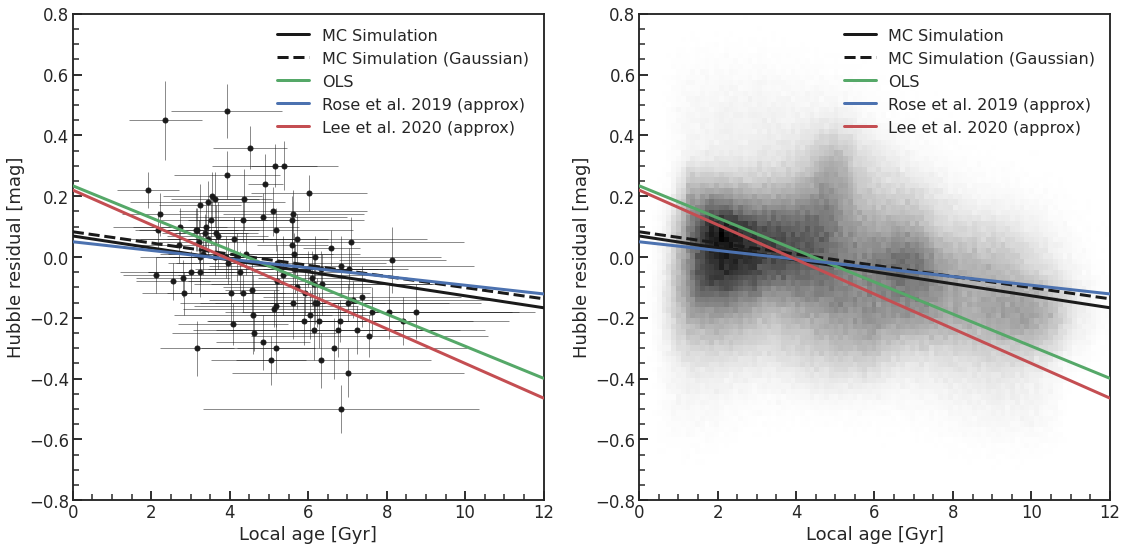

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
ax1, ax2 = axes

x, y = result_df['age'], result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

ax1.errorbar(age_df["age"].groupby('snid').mean(), hr_df["hr"], xerr=age_df["age"].groupby('snid').std(), yerr=hr_df['hr_err'], fmt='ko', lw=0.5, ms=5)
xrange = np.linspace(0, 12, 100)
ax1.plot(xrange, slope*xrange + intercept, c='k', lw=3, label=f"Bootstrap", zorder=100)

# Incorrect Simulation
x, y = result_gaussian_df['age'], result_gaussian_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

xrange = np.linspace(0, 12, 100)
ax1.plot(xrange, slope*xrange + intercept, c='k', linestyle='dashed', lw=3, label=f"Bootstrap (Gaussian)", zorder=100)


# OLS (no error)
x, y = age_df['age'].groupby('snid').mean(), hr_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)
ax1.plot(xrange, slope*xrange + intercept, c='g', lw=3, label=f"OLS", zorder=100)

# R19 Regression
slope = -0.1/7
intercept = 0.05
ax1.plot(xrange, slope*xrange + intercept, lw=3, label=f"Rose et al. 2019 (approx)", zorder=100)

# L20 Regression
slope = -0.057
intercept = 0.22
xrange = np.linspace(0, 12, 100)
ax1.plot(xrange, slope*xrange + intercept, c='r', lw=3, label=f"Lee et al. 2020 (approx)", zorder=100)

ax1.set_xlabel("Local age [Gyr]")
ax1.set_ylabel("Hubble residual [mag]")
ax1.set_xlim(0, 12)
ax1.set_xticks(np.arange(0, 14, 2))
ax1.set_yticks(np.arange(-0.8, 1, 0.2))
ax1.legend(loc='upper right')

plt.tight_layout()
plt.savefig(FIGURESPATH/"campbell_correlation_summary.pdf")